## 1 - Packages

In [1]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import tensorflow_datasets as tfds

<a name='2'></a>
## 2 - Load and Split the Data

In [2]:
os.environ['KAGGLE_USERNAME'] = "abdellahwalid"
os.environ['KAGGLE_KEY'] = "41185aba8848d5bc04c859bdf7eb05da"

In [3]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs -p '/content/'

 96% 194M/202M [00:03<00:00, 70.9MB/s]
100% 202M/202M [00:03<00:00, 66.4MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/cityscapes-image-pairs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
os.remove('/content/cityscapes-image-pairs.zip')

In [ ]:
import os
import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

train_image_mask_path = '/content/cityscapes_data/train/'
train_image_mask_list = os.listdir(train_image_mask_path)
train_image_mask_list = [train_image_mask_path+i for i in train_image_mask_list]

val_image_mask_path = '/content/cityscapes_data/val/'
val_image_mask_list = os.listdir(val_image_mask_path)
val_image_mask_list = [val_image_mask_path+i for i in val_image_mask_list]

### Check out the some of masks and  images from the dataset:

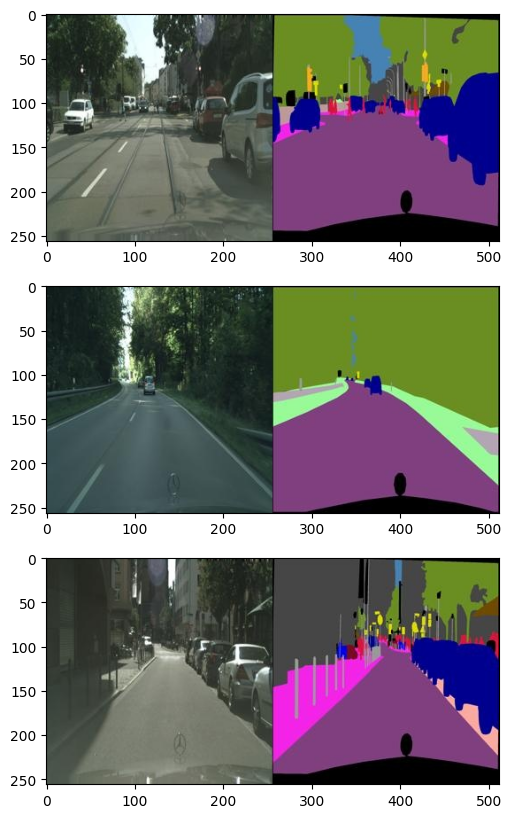

In [ ]:

fig, arr = plt.subplots(3, 1, figsize=(14, 10))
for i in range(3):
  arr[i].imshow(imageio.v2.imread(val_image_mask_list[i]))
plt.show()

<a name='2-1'></a>
### 2.1 - Split Dataset into Unmasked and Masked Images

In [ ]:
def process_path(image_mask_list):
  images = []
  maskes = []
  for f in image_mask_list:
    img = tf.io.read_file(f)
    img = tf.image.decode_png(img, channels=3)
    mask = img[:, img.shape[1]//2:, :]
    img = img[:, :img.shape[1]//2, :]
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    img = tf.image.convert_image_dtype(img, tf.float32)
    images.append(img)
    maskes.append(mask)
  return images, maskes

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    return input_image, input_mask

train_images_ds, train_maskes_ds = process_path(train_image_mask_list)
val_images_ds, val_maskes_ds = process_path(val_image_mask_list)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_ds, train_maskes_ds)).map(preprocess)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_ds, val_maskes_ds)).map(preprocess)

<a name='3'></a>
## 3 - U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used.

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

<a name='3-1'></a>
### 3.1 - Model Details

<img src="https://raw.githubusercontent.com/ahsan-83/Deep-Learning-Specialization-Coursera/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 valid padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection.

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. We need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when we use 1x1 convolutions, we can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, we can reduce the channel dimensions to have one layer per class.

The U-Net network has 23 convolutional layers in total.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block)

<img src="https://raw.githubusercontent.com/ahsan-83/Deep-Learning-Specialization-Coursera/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks.


In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, we'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="https://raw.githubusercontent.com/ahsan-83/Deep-Learning-Specialization-Coursera/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder.



In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,
                 3,
                 strides=2,
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

<a name='3-4'></a>
### 3.4 - Build the Model

This is where we'll put it all together, by chaining the encoder, bottleneck, and decoder! We'll need to specify the number of output channels, which for this particular set would be 256. That's because there are 256 possible labels for each pixel in this self-driving car dataset.



In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=256):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)

    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3)

    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below!

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

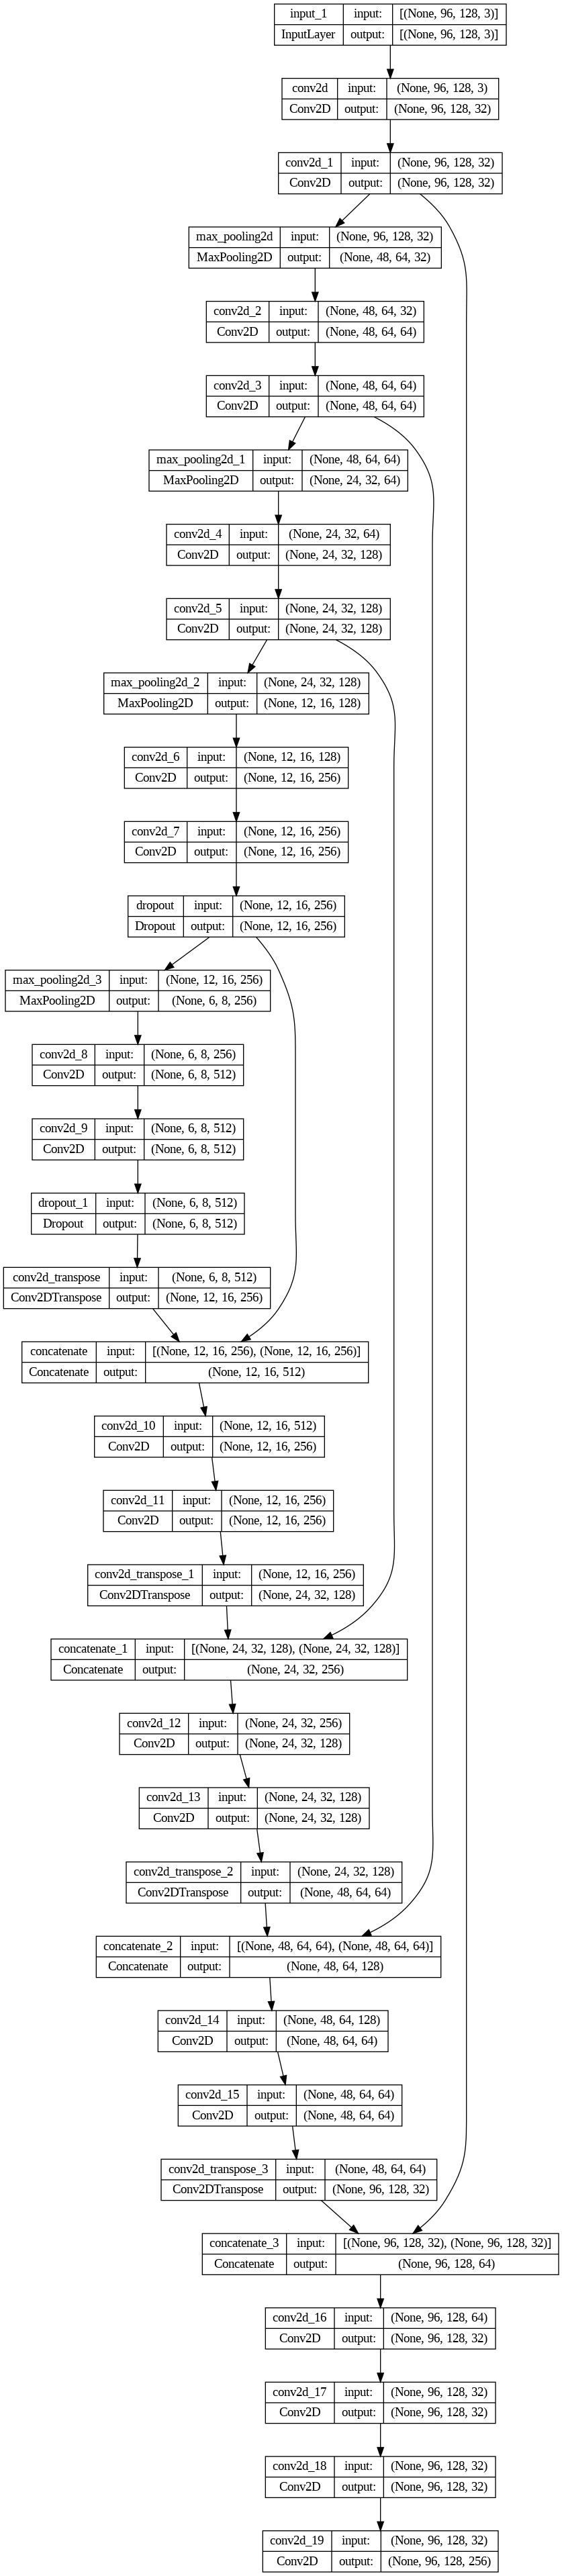

In [ ]:
tf.keras.utils.plot_model(unet, show_shapes=True, show_layer_names=True)

<a name='3-6'></a>
### 3.6 - Loss Function

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

<a name='4'></a>
## 4 - Train the Model

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/30
93/93 [==============================] - 51s 317ms/step - loss: 4.5662 - accuracy: 0.1942 - val_loss: 3.6345 - val_accuracy: 0.3139
Epoch 2/30
93/93 [==============================] - 23s 251ms/step - loss: 3.2054 - accuracy: 0.3767 - val_loss: 3.0355 - val_accuracy: 0.4043
Epoch 3/30
93/93 [==============================] - 24s 257ms/step - loss: 2.8773 - accuracy: 0.4275 - val_loss: 2.8215 - val_accuracy: 0.4369
Epoch 4/30
93/93 [==============================] - 24s 262ms/step - loss: 2.7258 - accuracy: 0.4461 - val_loss: 2.7114 - val_accuracy: 0.4465
Epoch 5/30
93/93 [==============================] - 24s 261ms/step - loss: 2.6037 - accuracy: 0.4598 - val_loss: 2.6078 - val_accuracy: 0.4598
Epoch 6/30
93/93 [==============================] - 24s 259ms/step - loss: 2.5287 - accuracy: 0.4752 - val_loss: 2.5521 - val_accuracy: 0.4751
Epoch 7/30
93/93 [==============================] - 25s 270ms/step - loss: 2.4353 - accuracy: 0.4976 - val_loss: 2.4386 - val_accuracy: 0.5031

<a name='4-1'></a>
### 4.1 - Create Predicted Masks


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model hestory

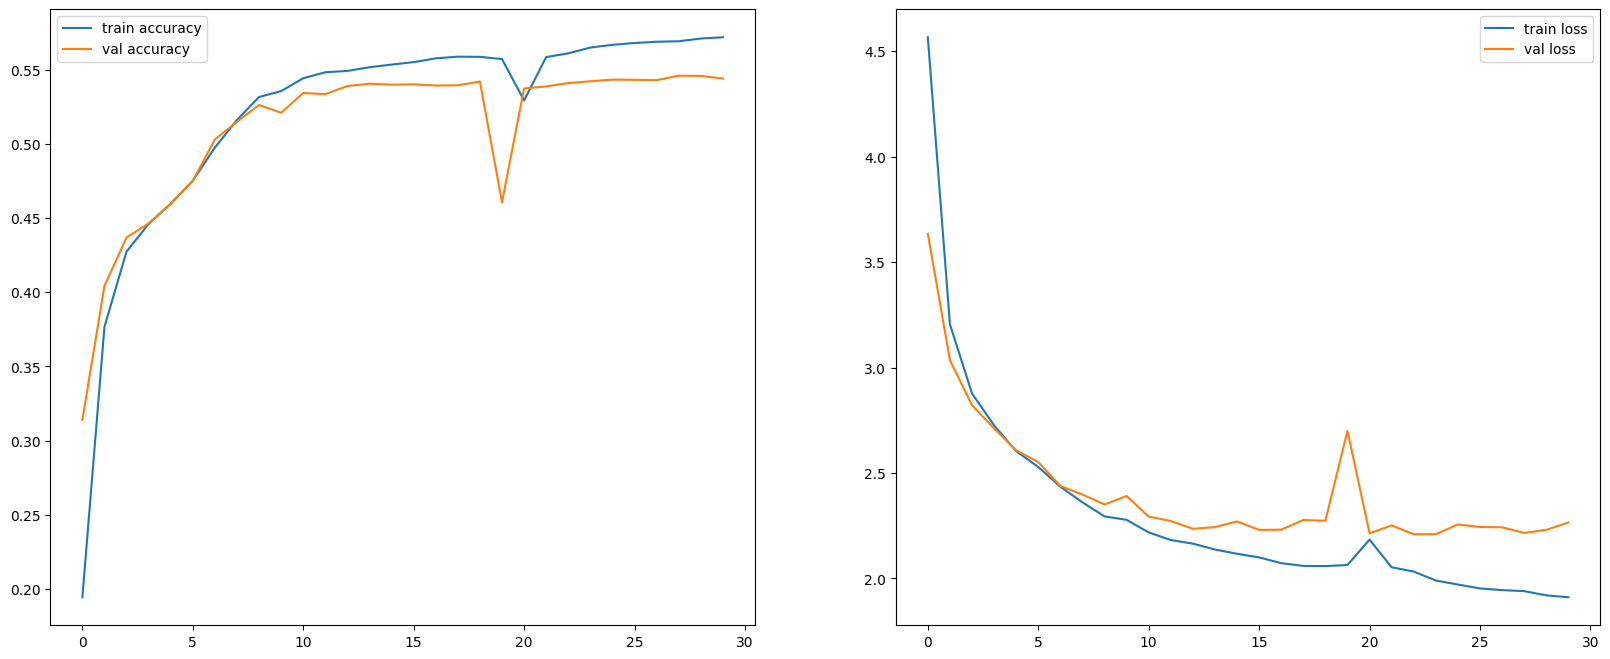

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2, 1)
plt.plot(model_history.history["accuracy"], label='train accuracy')
plt.plot(model_history.history["val_accuracy"], label='val accuracy')
plt.legend()

plt.subplot(1,2, 2)
plt.plot(model_history.history["loss"], label='train loss')
plt.plot(model_history.history["val_loss"], label='val loss')
plt.legend()

plt.show()

<a name='4-3'></a>
### 4.3 - Show Predictions


In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

1/1 [==============================] - 0s 65ms/step


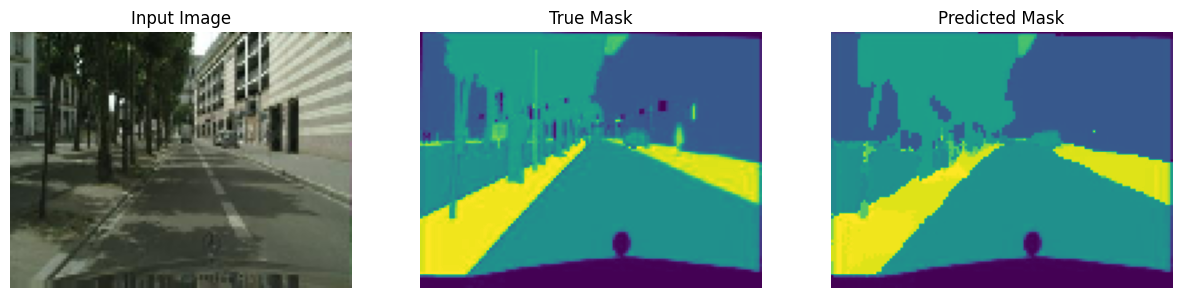

1/1 [==============================] - 0s 83ms/step


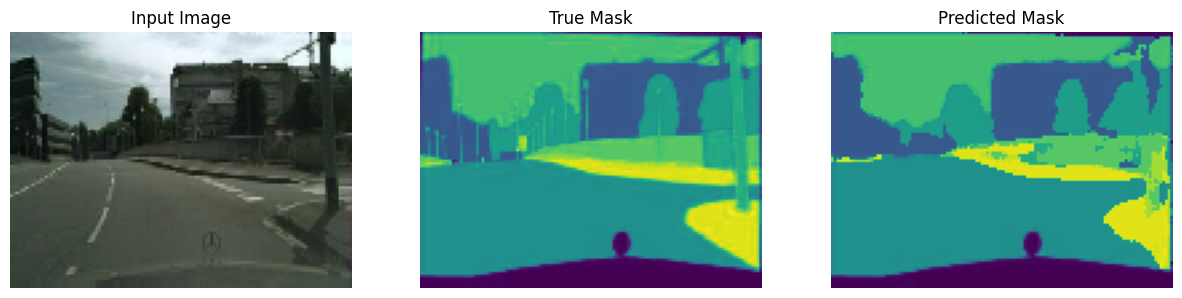

1/1 [==============================] - 0s 31ms/step


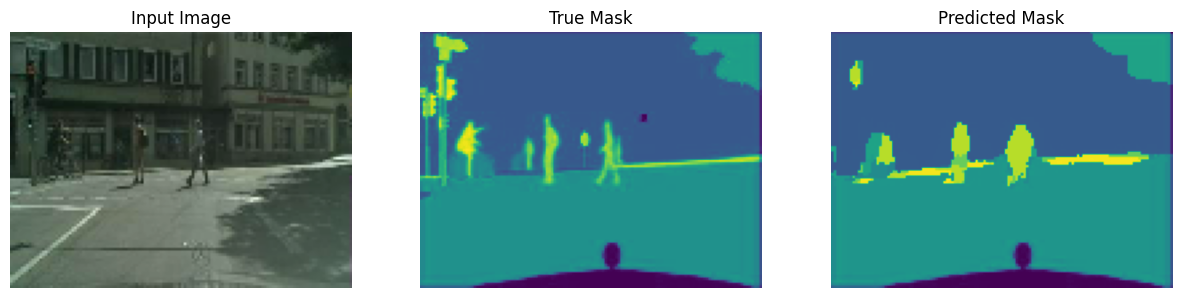

1/1 [==============================] - 0s 36ms/step


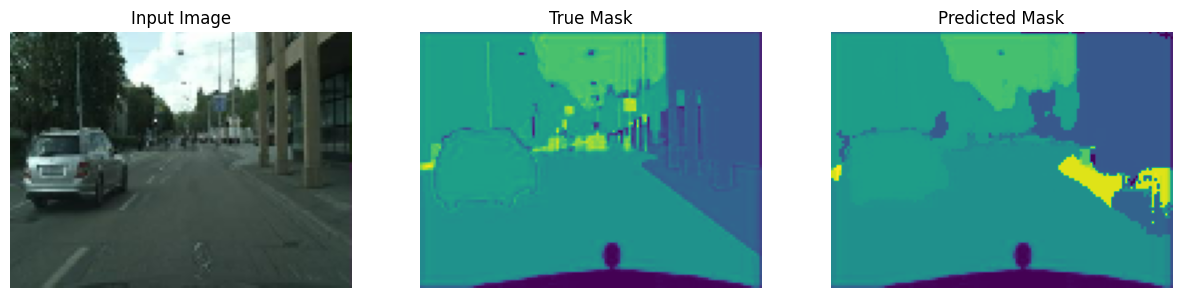

1/1 [==============================] - 0s 21ms/step


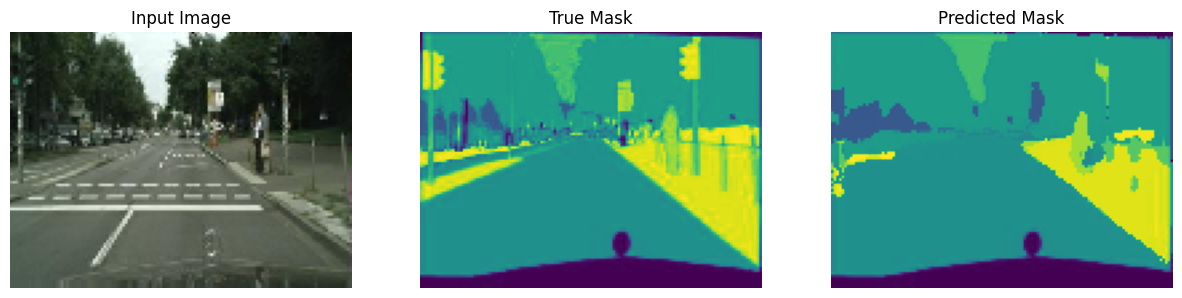

1/1 [==============================] - 0s 27ms/step


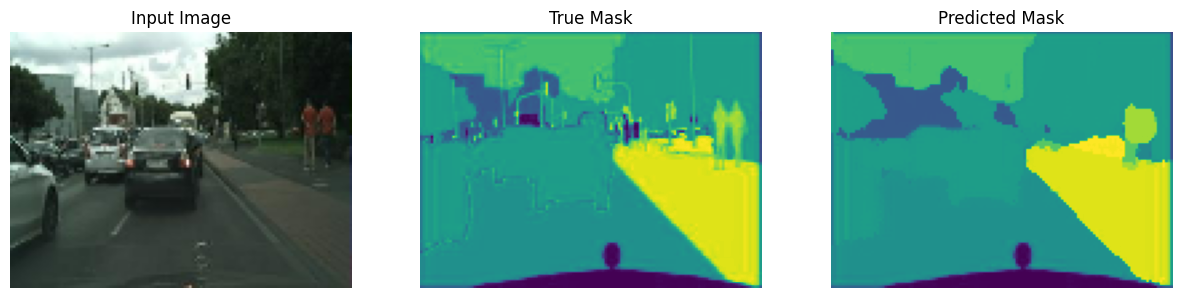

1/1 [==============================] - 0s 30ms/step


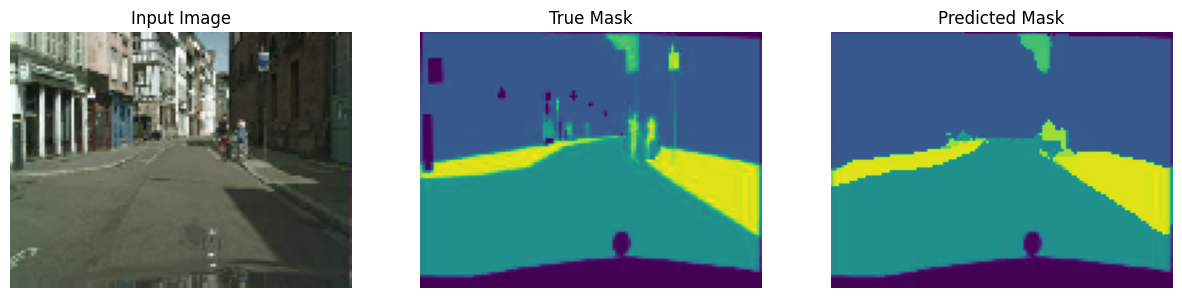

1/1 [==============================] - 0s 41ms/step


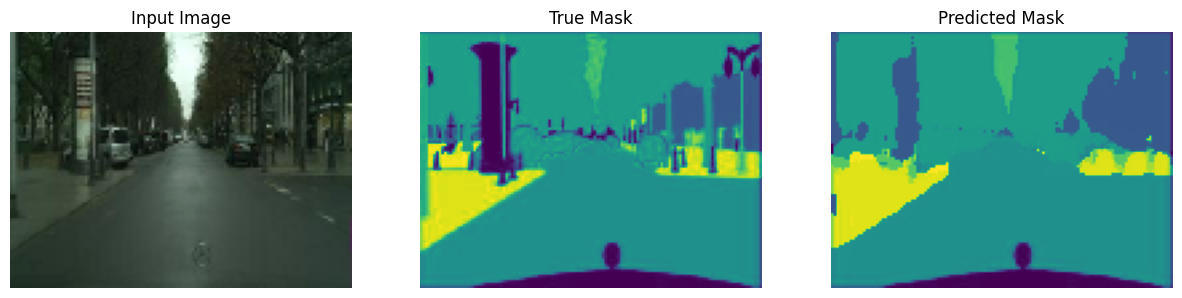

1/1 [==============================] - 0s 49ms/step


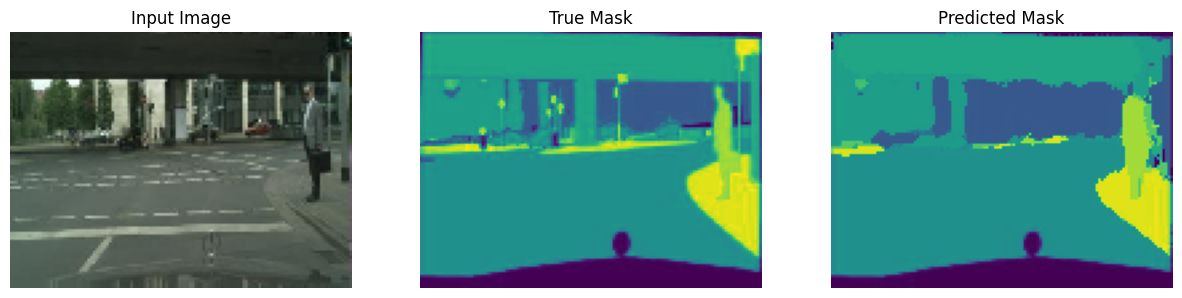

1/1 [==============================] - 0s 41ms/step


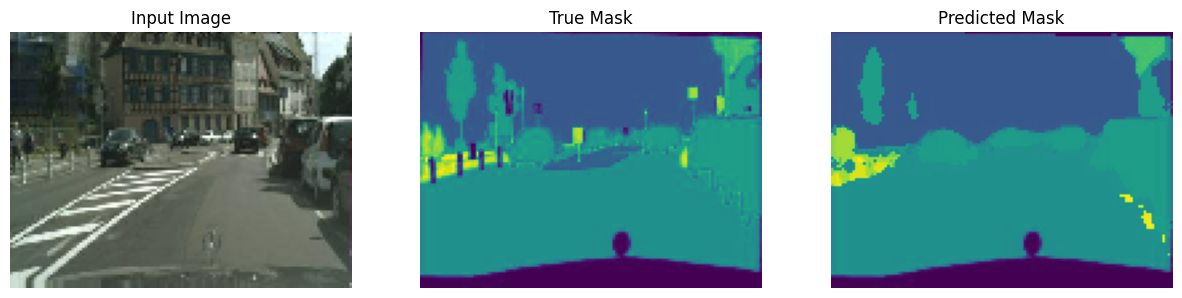

In [ ]:
show_predictions(train_dataset, 10)